In [5]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.utils.multiclass import unique_labels

import chardet

import warnings
warnings.filterwarnings("ignore")

In [9]:
with open(r'spam.csv', 'rb') as f:
    result = chardet.detect(f.read())
    

df = pd.read_csv(r'spam.csv', encoding=result['encoding'])
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [11]:
df.shape

(5572, 5)

In [13]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [15]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)

In [17]:
df.head(2)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [19]:
df.duplicated().sum()

403

In [21]:
df.drop_duplicates(inplace = True)

In [23]:
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df.head(2)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [25]:
df['message_length'] = df['message'].apply(len)
df.head()

,label,message,message_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [27]:
df.describe(include='object')

,label,message
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


In [29]:
df.groupby('label').describe().T

label                         ham        spam
message_length count  4516.000000  653.000000
               mean     70.459256  137.891271
               std      56.358207   30.137753
               min       2.000000   13.000000
               25%      34.000000  132.000000
               50%      52.000000  149.000000
               75%      90.000000  157.000000
               max     910.000000  224.000000

In [31]:
df['label'].value_counts()

label
ham     4516
spam     653
Name: count, dtype: int64

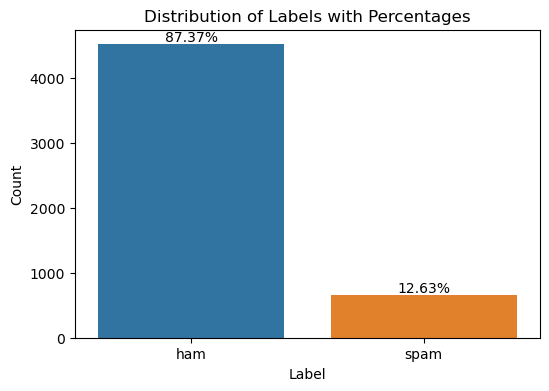

In [33]:
plt.figure(figsize=(6, 4))  
ax = sns.countplot(data=df, x='label')

total = float(len(df['label']))
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{(height/total)*100:.2f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black')


plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels with Percentages')


plt.show()

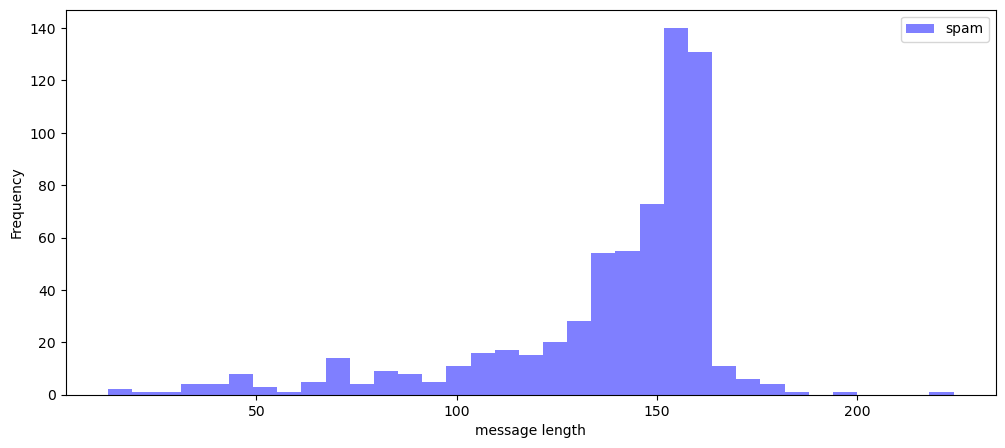

In [35]:
plt.figure(figsize=(12,5))
df[df['label']=='spam']['message_length'].plot(bins=35,kind='hist',color='blue',label='spam',alpha=0.5)
plt.legend()
plt.xlabel('message length')
plt.show()

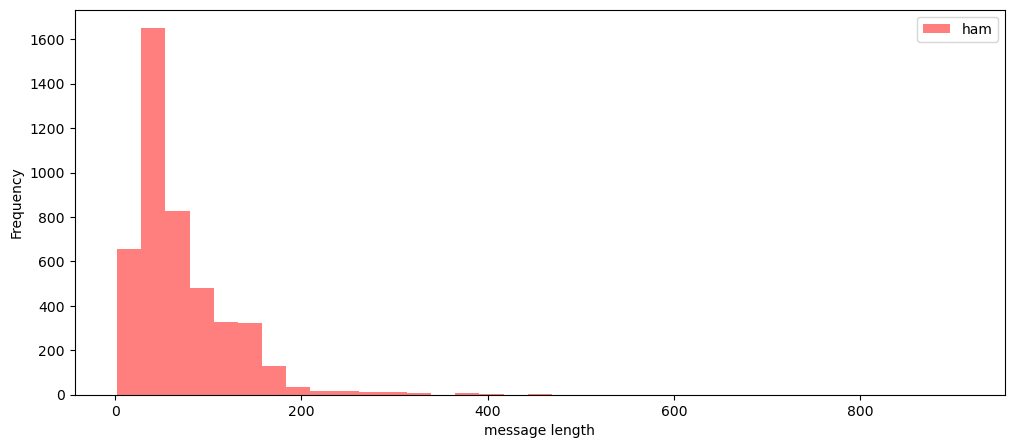

In [37]:
plt.figure(figsize=(12,5))
df[df['label']=='ham']['message_length'].plot(bins=35,kind='hist',color='red',label='ham',alpha=0.5)
plt.legend()
plt.xlabel('message length')
plt.show()

In [39]:
df.label.replace("ham",0,inplace = True)
df.label.replace("spam",1,inplace = True)

df['label'].value_counts()

label
0    4516
1     653
Name: count, dtype: int64

In [41]:
df_copy = df.copy()

In [47]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [49]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            if i.strip().isalpha():
                final_text.append(i.strip())
    return " ".join(final_text)


def denoise_text(text):
    text = strip_html(text)
    text = remove_stopwords(text)
    text = remove_stopwords(text)
    return text

In [51]:
df['clean_message']=df['message'].apply(denoise_text)
df.head(2)

,label,message,message_length,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",111,Go jurong Available bugis n great world la e C...
1,0,Ok lar... Joking wif u oni...,29,Ok Joking wif u


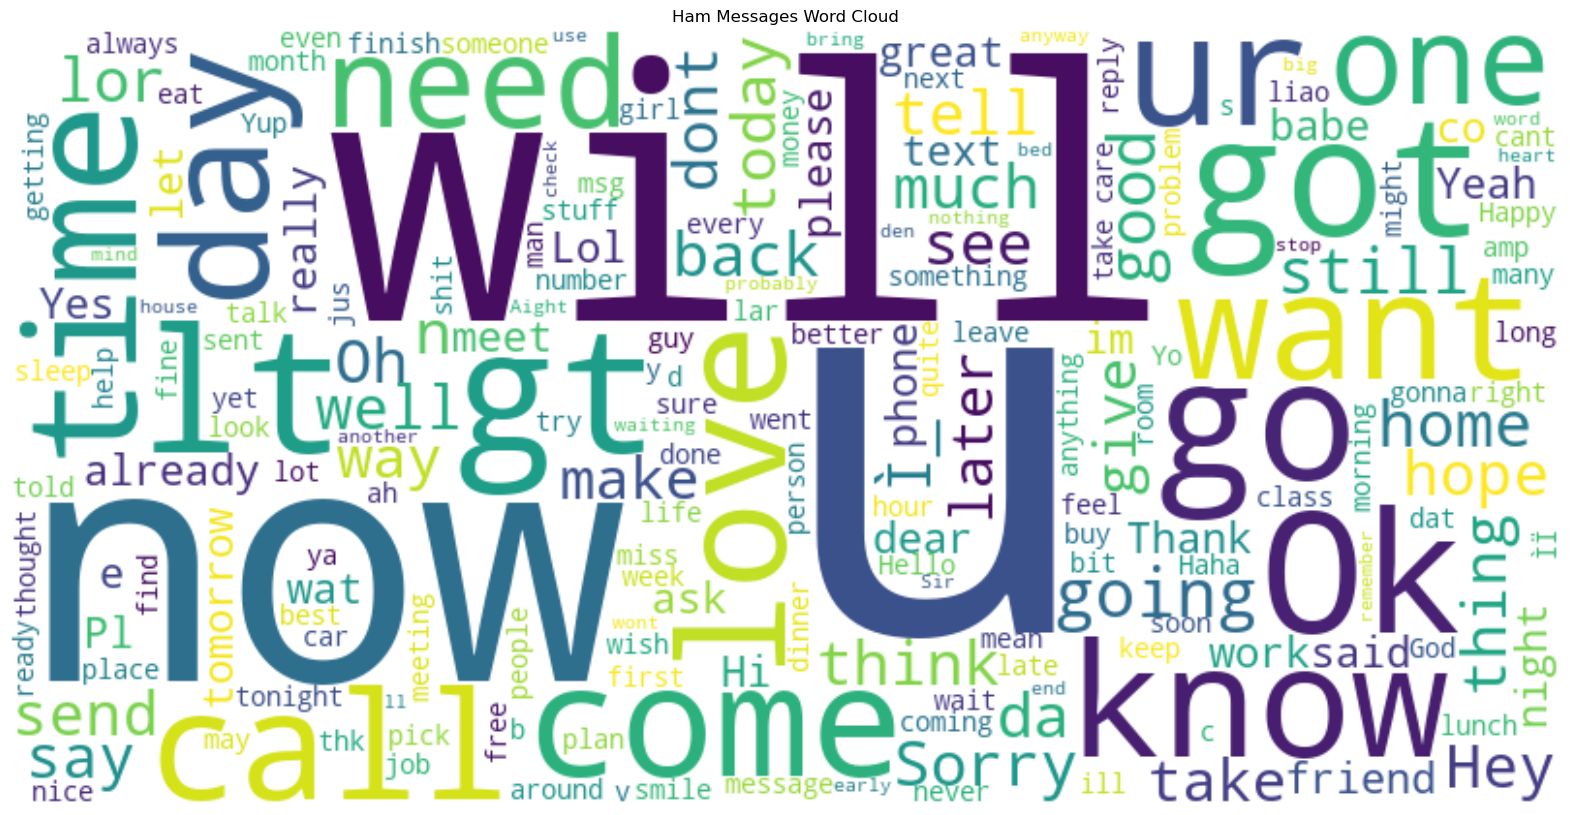

-------------------------------------------------------------------------------------------------------------------------------


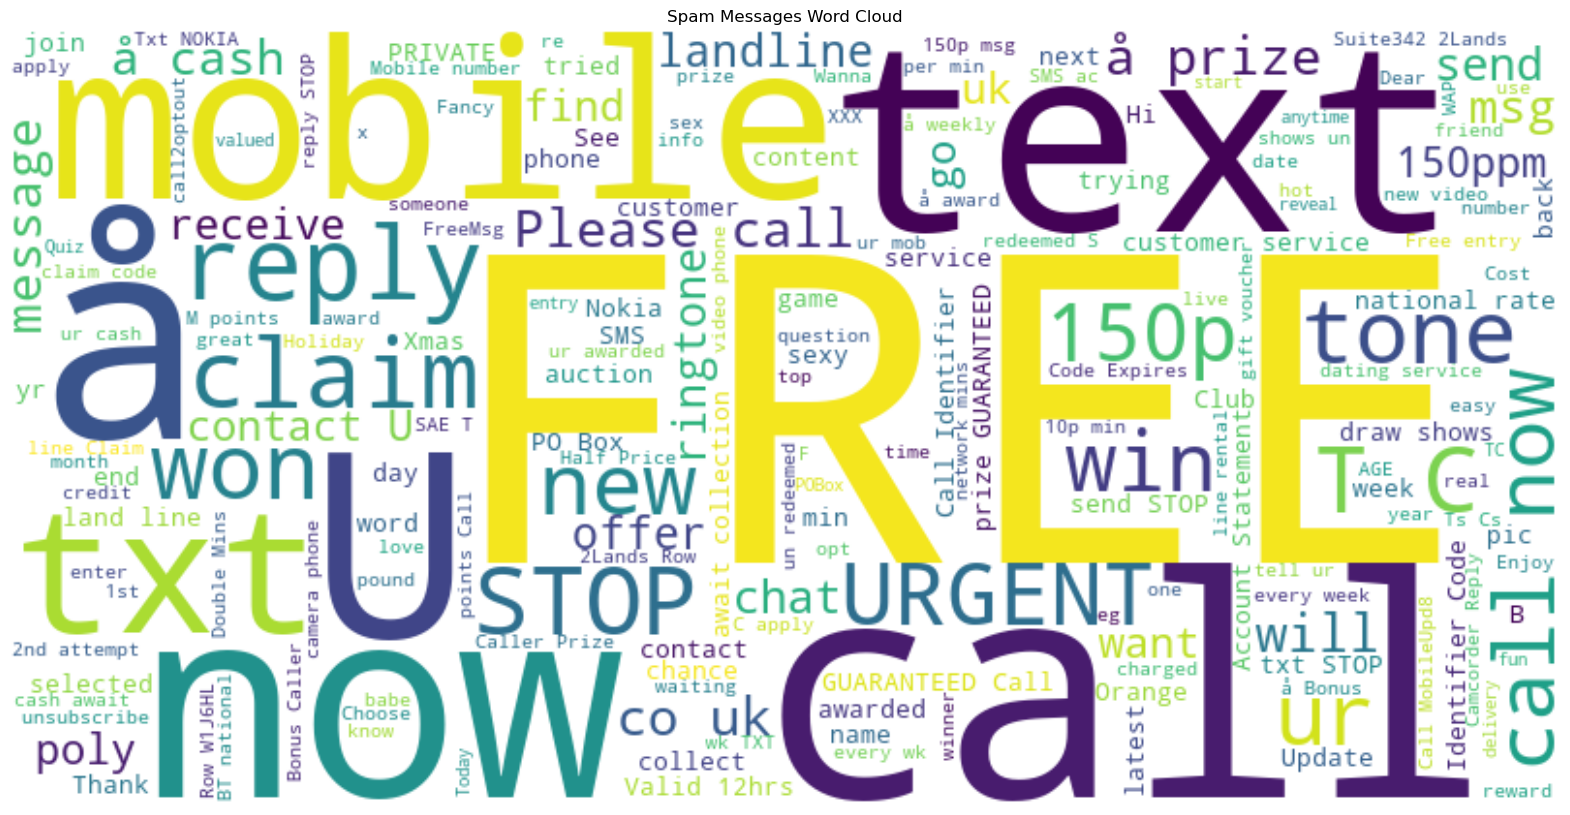

In [53]:

ham_messages = df[df['label'] == 0]['message']
spam_messages = df[df['label'] == 1]['message']


ham_text = " ".join(ham_messages)


spam_text = " ".join(spam_messages)


ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)


spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)


plt.figure(figsize=(20, 20))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Messages Word Cloud')
plt.axis('off')
plt.show()

print('-'*127)


plt.figure(figsize=(20, 20))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Messages Word Cloud')
plt.axis('off')
plt.show()

In [59]:
snowball_stemmer = SnowballStemmer('english')

preprocessed_messages = []

for _, row in df.iterrows():
    review = re.sub('[^a-zA-Z]', ' ', row['message'])
    review = review.lower()
    tokens = word_tokenize(review)
    tokens = [snowball_stemmer.stem(word) for word in tokens if not word in stopwords.words('english')]
    preprocessed_review = ' '.join(tokens)
    preprocessed_messages.append(preprocessed_review)


df['clean_message'] = df['clean_message']


df

,label,message,message_length,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",111,Go jurong Available bugis n great world la e C...
1,0,Ok lar... Joking wif u oni...,29,Ok Joking wif u
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts May...
3,0,U dun say so early hor... U c already then say...,49,U dun say early U c already
4,0,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes lives around though
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,time tried contact U Pound claim call per
5568,0,Will Ì_ b going to esplanade fr home?,37,b going esplanade fr
5569,0,"Pity, * was in mood for that. So...any other s...",57,mood
5570,0,The guy did some bitching but I acted like i'd...,125,guy bitching acted like interested buying some...


In [61]:
df['clean_message_length'] = df['clean_message'].apply(len)


df

,label,message,message_length,clean_message,clean_message_length
0,0,"Go until jurong point, crazy.. Available only ...",111,Go jurong Available bugis n great world la e C...,59
1,0,Ok lar... Joking wif u oni...,29,Ok Joking wif u,15
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry wkly comp win FA Cup final tkts May...,78
3,0,U dun say so early hor... U c already then say...,49,U dun say early U c already,27
4,0,"Nah I don't think he goes to usf, he lives aro...",61,Nah think goes lives around though,34
...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,time tried contact U Pound claim call per,41
5568,0,Will Ì_ b going to esplanade fr home?,37,b going esplanade fr,20
5569,0,"Pity, * was in mood for that. So...any other s...",57,mood,4
5570,0,The guy did some bitching but I acted like i'd...,125,guy bitching acted like interested buying some...,79


In [63]:
X = df['clean_message']
y = df['label']

In [65]:
tf = TfidfVectorizer()

tfTrainReviews = tf.fit_transform(X)

tfTrainReviews

<5169x6012 sparse matrix of type '<class 'numpy.float64'>'
	with 30663 stored elements in Compressed Sparse Row format>

In [67]:
tfTrainReviews.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [69]:
feature_names = tf.get_feature_names_out()
tfidf_df = pd.DataFrame(tfTrainReviews.toarray(), columns=feature_names)
tfidf_df.head()

,aa,aah,aaniye,aaooooright,abdomen,abi,ability,abiola,abj,able,...,zhong,zindgi,zoe,zoom,zouk,zyada,åð,åòharry,åôrents,ìï
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
X_train, X_test, y_train, y_test = train_test_split(tfTrainReviews, y, test_size = 0.20, random_state = 42)

In [73]:
print("X_train shape: {}\nX_test shape: {}\nY_train shape: {}\nY_test shape: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))


X_train shape: (4135, 6012)
X_test shape: (1034, 6012)
Y_train shape: (4135,)
Y_test shape: (1034,)


In [75]:
random_state = 42
n_jobs = -1


classifiers = [
    LogisticRegression(random_state=random_state, n_jobs=n_jobs),
    DecisionTreeClassifier(random_state=random_state),
    KNeighborsClassifier(n_jobs=n_jobs),
    MultinomialNB(),
    AdaBoostClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, n_jobs=n_jobs),
    XGBClassifier(random_state=random_state, n_jobs=n_jobs),
    SVC(random_state=random_state)
]

results = []


for classifier in classifiers:
    start_time = time.time()
    
    
    classifier.fit(X_train, y_train)
    
    
    y_train_pred = classifier.predict(X_train)
    
 
    y_test_pred = classifier.predict(X_test)
    
    
    train_accuracy = np.mean(y_train_pred == y_train)
    train_report = classification_report(y_train, y_train_pred, output_dict=True)
    train_precision = train_report['weighted avg']['precision']
    train_recall = train_report['weighted avg']['recall']
    train_f1 = train_report['weighted avg']['f1-score']
    train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
    
  
    test_accuracy = np.mean(y_test_pred == y_test)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    test_precision = test_report['weighted avg']['precision']
    test_recall = test_report['weighted avg']['recall']
    test_f1 = test_report['weighted avg']['f1-score']
    test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
    

    build_time = time.time() - start_time
    
   
    results.append([classifier.__class__.__name__, train_accuracy, train_precision, train_recall, train_f1, train_balanced_acc, 
                    test_accuracy, test_precision, test_recall, test_f1, test_balanced_acc, build_time])


columns = ["Algorithm", 
           "Train Accuracy", "Train Precision", "Train Recall", "Train F1-score", "Train Balanced Accuracy",
           "Test Accuracy", "Test Precision", "Test Recall", "Test F1-score", "Test Balanced Accuracy",
           "Building Time (s)"]

results_df = pd.DataFrame(results, columns=columns)


print("Model Performance on Training and Test Sets")
results_df

Model Performance on Training and Test Sets


,Algorithm,Train Accuracy,Train Precision,Train Recall,Train F1-score,Train Balanced Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1-score,Test Balanced Accuracy,Building Time (s)
0,LogisticRegression,0.954776,0.955225,0.954776,0.950952,0.826102,0.935203,0.934101,0.935203,0.929193,0.792052,0.736749
1,DecisionTreeClassifier,0.999516,0.999517,0.999516,0.999516,0.998031,0.937137,0.936958,0.937137,0.937046,0.868209,0.178165
2,KNeighborsClassifier,0.923337,0.929499,0.923337,0.907559,0.687992,0.906190,0.915418,0.906190,0.885042,0.665517,0.459946
3,MultinomialNB,0.961064,0.962719,0.961064,0.957821,0.841535,0.951644,0.953593,0.951644,0.947484,0.830472,0.007996
4,AdaBoostClassifier,0.969045,0.968535,0.969045,0.967859,0.893483,0.949710,0.948035,0.949710,0.947596,0.858206,1.324516
5,GradientBoostingClassifier,0.968319,0.968925,0.968319,0.966438,0.875295,0.953578,0.953566,0.953578,0.950564,0.848912,2.777675
6,RandomForestClassifier,0.999516,0.999517,0.999516,0.999516,0.998031,0.965184,0.965778,0.965184,0.963332,0.881634,0.637663
7,XGBClassifier,0.984281,0.984511,0.984281,0.983829,0.936870,0.963250,0.962392,0.963250,0.962340,0.900710,0.215356
8,SVC,0.994438,0.994458,0.994438,0.994387,0.978209,0.964217,0.964258,0.964217,0.962516,0.883957,0.881642


In [77]:
random_forest_classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [79]:
y_train_pred = random_forest_classifier.predict(X_train)


y_test_pred = random_forest_classifier.predict(X_test)


train_report = classification_report(y_train, y_train_pred, output_dict=True)
train_accuracy = train_report['accuracy']
train_precision = train_report['weighted avg']['precision']
train_recall = train_report['weighted avg']['recall']
train_f1 = train_report['weighted avg']['f1-score']
train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)


test_report = classification_report(y_test, y_test_pred, output_dict=True)
test_accuracy = test_report['accuracy']
test_precision = test_report['weighted avg']['precision']
test_recall = test_report['weighted avg']['recall']
test_f1 = test_report['weighted avg']['f1-score']
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Balanced Accuracy'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1, train_balanced_acc],
    'Test': [test_accuracy, test_precision, test_recall, test_f1, test_balanced_acc]
})


results_df

,Metric,Train,Test
0,Accuracy,0.999516,0.965184
1,Precision,0.999517,0.965778
2,Recall,0.999516,0.965184
3,F1-score,0.999516,0.963332
4,Balanced Accuracy,0.998031,0.881634


In [83]:
train_report = classification_report(y_train, y_train_pred)
print("Classification Report for Training Data:\n", train_report)

print('-'*127)

test_report = classification_report(y_test, y_test_pred)
print("Classification Report for Test Data:\n", test_report)

Classification Report for Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3627
           1       1.00      1.00      1.00       508

    accuracy                           1.00      4135
   macro avg       1.00      1.00      1.00      4135
weighted avg       1.00      1.00      1.00      4135

-------------------------------------------------------------------------------------------------------------------------------
Classification Report for Test Data:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       0.98      0.77      0.86       145

    accuracy                           0.97      1034
   macro avg       0.97      0.88      0.92      1034
weighted avg       0.97      0.97      0.96      1034



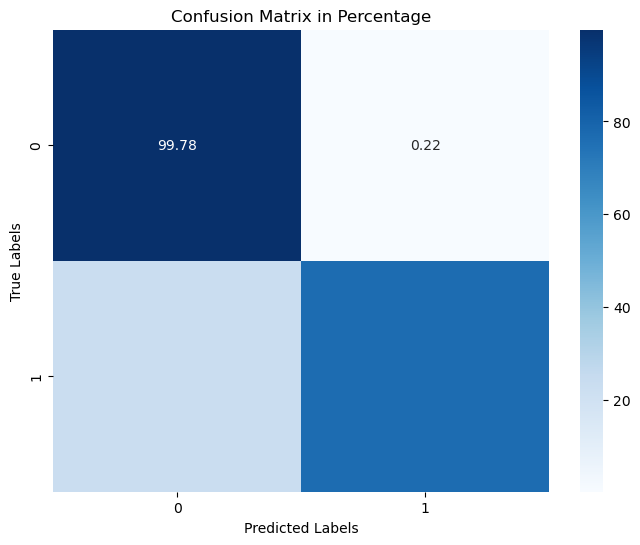

In [85]:
cm = confusion_matrix(y_test, y_test_pred)


cm_percent = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100


class_labels = unique_labels(y_test, y_test_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix in Percentage')
plt.show()

In [87]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(random_forest_classifier, X_train, y_train, cv=5, scoring='accuracy',n_jobs=-1)

print("Cross-Validation Scores (Accuracy):", scores)
print()
print("Mean Accuracy Score:", scores.mean())

Cross-Validation Scores (Accuracy): [0.95888755 0.96130593 0.9637243  0.96614268 0.96735187]

Mean Accuracy Score: 0.9634824667472792


In [89]:
import joblib

model = random_forest_classifier

joblib.dump(model, 'Ham_Vs_Spam_Classifier.pkl')

['Ham_Vs_Spam_Classifier.pkl']